<a href="https://colab.research.google.com/github/udbhav-44/Sentiment_analysis_tweets/blob/main/Sentimental_analysis3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 2 - Sentiment Analysis on Twitter**

The objective of this task is to **detect hate speech** in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where **label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist**, your objective is to predict the labels on the test dataset.

### Loading Libraries
Importing all the required libraries


In [ ]:
import re               # for regular expressions
import pandas as pd
import numpy as np
import nltk
import warnings
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", 200)           #sets the maximum width for displaying columns in pandas dataframes to 200 characters
warnings.filterwarnings("ignore", category=DeprecationWarning)  #Ignores all Deprecation warnings
%matplotlib inline

### **Loading Training and Testing Dataset**

In [ ]:
#Loading the Training Data in a Pandas DataFrame
df_train = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/train.csv')

#Getting the number of Racist/Sexist(1) and Non-Racist/Sexist(0)
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
#Loading the Testing Data in a Pandas DataFrame
df_test = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/test.csv')

### **Data Inspection**

In [ ]:
#Displaying the first 100 Non-racist/sexist Tweets in the data
display(df_train[df_train['label']==0].head(100))
print('')

#Displaying the first 100 racist/sexist Tweets in the data
display(df_train[df_train['label']==1].head(100))

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation
...,...,...,...
104,105,0,going to la tomorrow!!!
105,106,0,i am thankful for good friends. #thankful #positive
106,107,0,i still can not wrap my head around the fact that #christinagrimmie is gone. and the fact that a man destroyed #prayfororlando just
107,108,0,just received dis from @user can't wait to sta baking #eyelids .ðððððð ðððâ¦


,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
...,...,...,...
1366,1367,1,@user @user @user because we have been #shuckin'andjivin for the #democraticpay that only want our vote!
1374,1375,1,if you didn't like or #hitler you're definitely not going to like #traitor. #trump
1382,1383,1,just because you #liberals are self-loathing doesn't mean the rest of us are. the only weapon you have is to yellâ¦
1392,1393,1,@user buffalo school districts boots trump ally over racist comments. #birdsofafeather #resist :


In [ ]:
#Dimensions of the train and test dataset.
print("Train Dataset Shape: ",df_train.shape,"\nTest Dataset Shape: ",df_test.shape)
print('')
#print(df_train['label'].value_counts())

#Percentage of Racist and Non-Racist Tweets.
percent = len(df_train[df_train['label']==1])*100/len(df_train['label'])
print('\nPercentage of Racisct Tweets in the Training Data: ',percent)
print('Percent Non-Racist Tweets in the Training Data: ',100-percent)

Train Dataset Shape:  (31962, 3) 
Test Dataset Shape:  (17197, 2)


Percentage of Racisct Tweets in the Training Data:  7.014579813528565
Percent Non-Racist Tweets in the Training Data:  92.98542018647143


### **Data Visualization**

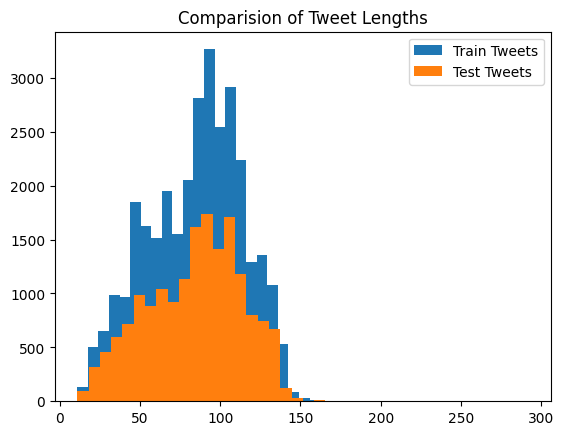

In [ ]:
#Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

length_train = df_train['tweet'].str.len()
length_test = df_test['tweet'].str.len()

plt.hist(length_train,bins=40,label='Train Tweets')
plt.hist(length_test,bins=40,label='Test Tweets')
plt.legend()
plt.title('Comparision of Tweet Lengths')
plt.show()


### **Data Cleaning**

To clean the raw tweets in our data


*   We will remove the Twitter handles as they are already masked as @user due to privacy concerns. These Twitter handles hardly give any information about the nature of the tweet.
*   We will also get rid of the punctuations, numbers, and even special characters since they wouldn’t help in differentiating different types of tweets
*   Most of the smaller words do not add much value. For example, ‘pdx’, ‘his’, ‘all’. So, we will try to remove them as well from our data.
*   Lastly, we will normalize(Stemming and Lemmatization) the text data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context. If we can reduce them to their root word, which is ‘love’. It will help in reducing the total number of unique words in our data without losing a significant amount of information



In [ ]:
#Combining Test and Train Datasets for Data Cleaning
combined_df = pd.concat([df_train, df_test], axis=0)

# Reset the index of the combined data frame
combined_df = combined_df.reset_index(drop=True)

print(combined_df.shape)
display(combined_df)

(49159, 3)


,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation
...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization"
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset"


In [ ]:
#function to remove unwanted text patterns from the tweet
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

#function to replace non alphanumeric with space from the tweet
def replace_non_alphanumeric_with_space(string):
    replaced_string = re.sub(r'[^a-zA-Z0-9#]+', ' ', string)
    return replaced_string



In [ ]:
#Removing @user from all tweets
combined_df['tidy_tweet'] = combined_df['tweet'].apply(lambda x: remove_pattern(x, "@[user]*"))

#Removing Unwanted and un-necessary punctuations and symbols
combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(replace_non_alphanumeric_with_space)

#combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace(r'[\W_]+', " ")

combined_df.head(10)

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,2 2 huge fan fare and big talking before they leave chaos and pay disputes when they get there #allshowandnogo
6,7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦,camping tomorrow danny
7,8,0.0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl,the next school year is the year for exams can t think about that #school #exams #hate #imagine #actorslife #revolutionschool #girl
8,9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦,we won love the land #allin #cavs #champions #cleveland #clevelandcavaliers
9,10,0.0,@user @user welcome here ! i'm it's so #gr8 !,welcome here i m it s so #gr8


In [ ]:
#Removing Short Words
combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
combined_df

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,thought factory left right polarisation #trump #uselections2016 #leadership #politics #brexit #blm
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,feeling like mermaid #hairflip #neverready #formal #wedding #gown #dresses #mermaid
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",#hillary #campaigned today #ohio used words like assets liability never once #clinton thee word #radicalization
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",happy work conference right mindset leads culture development organizations #work #mindset


Here we will use nltk’s PorterStemmer() function to normalize the tweets.
 But before that,  

*   we will have to tokenize the tweets.



**Tokens** are individual terms or words, and tokenization is the process of splitting a string of text into tokens




In [ ]:
#Tokenization
tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing
print(tokenized_tweet.head())
print('')

#Text Normalization
from nltk.stem.porter import *

stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

#Detokenization
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combined_df['tidy_tweet'] = tokenized_tweet

display(combined_df)

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object



,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunct selfish drag kid into dysfunct #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thank #lyft credit caus they offer wheelchair van #disapoint #getthank
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv
...,...,...,...,...
49154,49155,NaN,thought factory: left-right polarisation! #trump #uselections2016 #leadership #politics #brexit #blm &gt;3,thought factori left right polaris #trump #uselections2016 #leadership #polit #brexit #blm
49155,49156,NaN,feeling like a mermaid ð #hairflip #neverready #formal #wedding #gown #dresses #mermaid â¦,feel like mermaid #hairflip #neverreadi #formal #wed #gown #dress #mermaid
49156,49157,NaN,"#hillary #campaigned today in #ohio((omg)) &amp; used words like ""assets&amp;liability"" never once did #clinton say thee(word) #radicalization",#hillari #campaign today #ohio use word like asset liabil never onc #clinton thee word #radic
49157,49158,NaN,"happy, at work conference: right mindset leads to culture-of-development organizations #work #mindset",happi work confer right mindset lead cultur develop organ #work #mindset


# **Insights and visualization from cleaned tweets**

Making a WordClouds to visualize the most frequent Words. The WordClouds Shown Below are:
* All Tweet Text Data WordCloud
* Normal/positive tweets WordCloud
* Racist Words WordCloud
* Regular Hashtags WordClouds
* Negative/Racist Hashtags Wordcloud

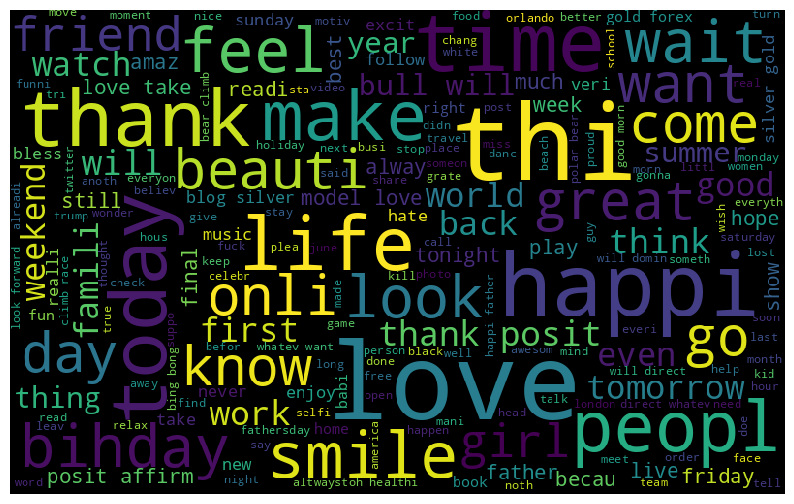


collecting the most frequent words visible in the wordCloud
love: 1.0
thi: 0.9570785739010038
happi: 0.6452059536171686
time: 0.5517480096919349
today: 0.5105572862582208
thank: 0.5088265835929388
life: 0.45794392523364486
peopl: 0.41259951540325374
make: 0.4001384562132226
smile: 0.34890965732087226


In [ ]:
all_words = ' '.join([text for text in combined_df['tidy_tweet']])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21,
                     max_font_size = 110).generate(all_words)
plt.figure(figsize = (10,7))
plt.imshow(wordcloud, interpolation = 'nearest')
plt.axis('off')
plt.show()
print('')
print('collecting the most frequent words visible in the wordCloud')

# Getting the word frequencies from the word cloud
word_frequencies = wordcloud.words_

# Sorting the word frequencies in descending order
sorted_word_frequencies = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)

# Extract the most frequent words and their frequencies
top_words = sorted_word_frequencies[:10]  # Change the number as desired

# Print the most frequent words and their frequencies
for word, frequency in top_words:
    print(f"{word}: {frequency}")

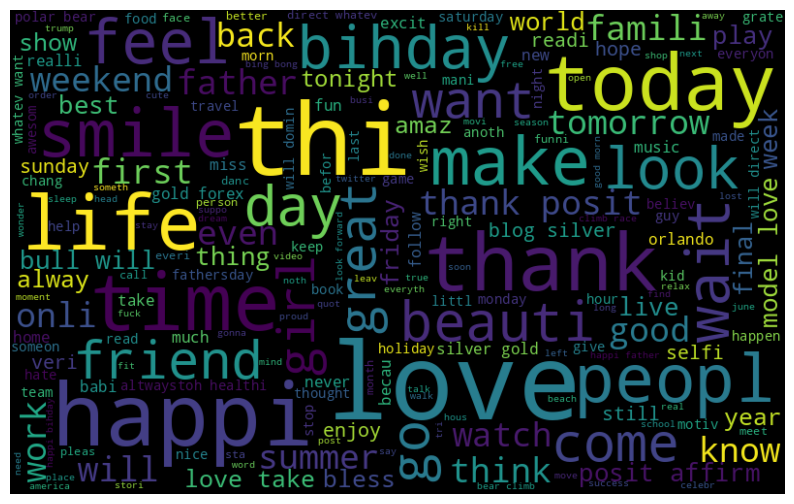

In [ ]:
#Most common words in normal/positive tweets
normal_words = ' '.join([text for text in combined_df['tidy_tweet'][combined_df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, random_state = 21, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

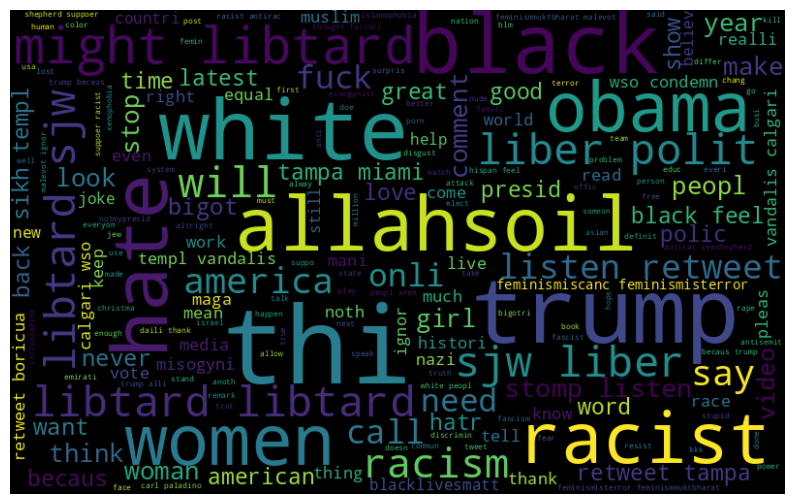

In [ ]:
#racist Words
negative_words = ' '.join([text for text in combined_df['tidy_tweet'][combined_df['label'] == 1]])

wordcloud = WordCloud(width = 800, height = 500, random_state = 21,max_font_size = 110).generate(negative_words)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
#Exploring hashtags on tweets sentiment

# Defining a function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

#extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combined_df['tidy_tweet']
                            [combined_df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combined_df['tidy_tweet']
                            [combined_df['label']== 1])

# Unnesting/flattening list
HT_regular = sum(HT_regular, [])
HT_negative = sum(HT_negative, [])
#HT_regular

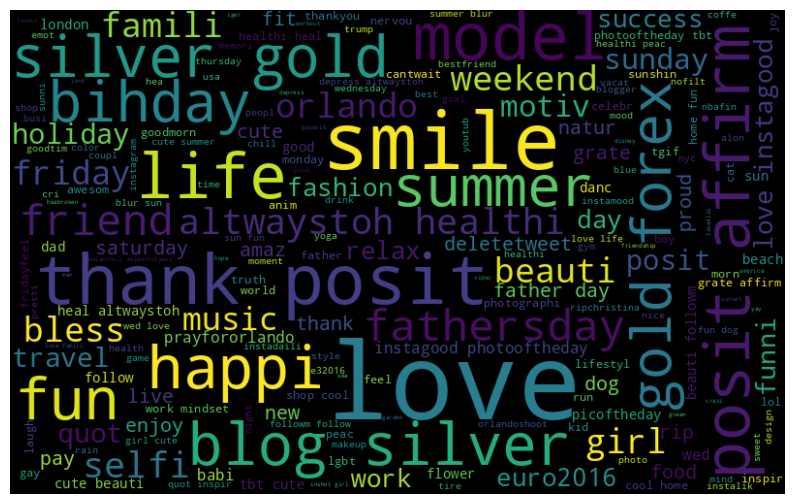

In [ ]:
regular_hash = ' '.join([text for text in HT_regular])

wordcloud = WordCloud(width = 800, height = 500, random_state = 21,max_font_size = 110).generate(regular_hash)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

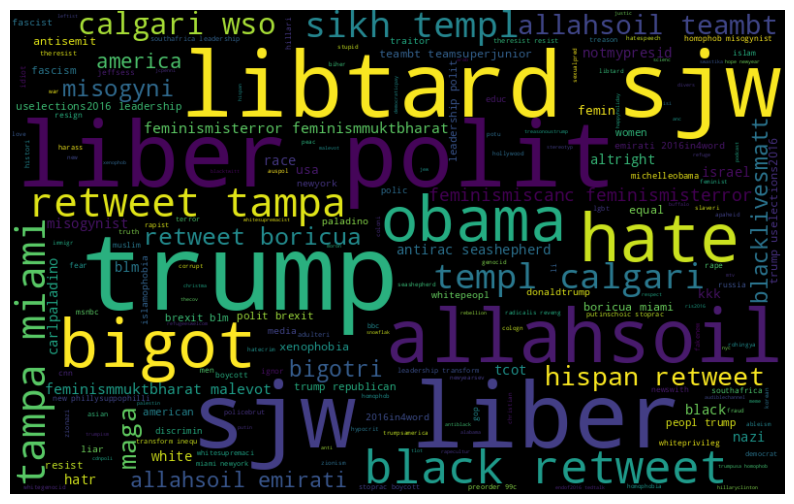

In [ ]:
negative_hash = ' '.join([text for text in HT_negative])

wordcloud = WordCloud(width = 800, height = 500, random_state = 21,max_font_size = 110).generate(negative_hash)
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# **Extracting Features from Cleaned Tweets**
To analyze preprocessed data, it needs to be converted into features.
Feature Extraction has been done through 3 models respectively:
* Bag Of Words (BOW)
* TF-IDF Model
* Word2Vec Model

In [ ]:
#BagOfWords
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import gensim

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000,   stop_words='english')
bow = bow_vectorizer.fit_transform(combined_df['tidy_tweet'])
bow.shape



(49159, 1000)

In [ ]:
#TF-IDF Model
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000,
                     stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combined_df['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [ ]:
#Word2Vec Model
tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing
model_w2v = gensim.models.Word2Vec(tokenized_tweet,vector_size=200, window=5,min_count = 2,sg = 1,hs= 0,negative = 10,workers =2,seed= 34)
model_w2v.train(tokenized_tweet, total_examples= len(combined_df['tidy_tweet']), epochs=20)

#Testing the Word2Vec
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.5627181529998779),
 ('hillari', 0.5534180998802185),
 ('phoni', 0.543576717376709),
 ('#delegaterevolt', 0.5432272553443909),
 ('melo', 0.5406209826469421),
 ('tomlin', 0.5341961979866028),
 ('businessman', 0.5328205227851868),
 ('unfit', 0.5254517793655396),
 ('potu', 0.5228871703147888),
 ('nomine', 0.5220096111297607)]

Preparing Vectors for Tweets

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i, :] = word_vector(tokenized_tweet[i], 200)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape


(49159, 200)

# **Model Building**

We are now done with all the pre-modelling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections —
* Bag-of-Words
* TF-IDF
* Word2Vec vectors

We will use the Logistic Regression algorithms to build model



**Evaluation Metric**

Following Evaluation Metrics are being used:
* F1 Score
* Accuracy Score
* ROC-AUC Score

In [ ]:

# Importing the Required Libraries and modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score as sklearn_roc_auc_score


### **Bag Of Words**
* Fitting the logistic regression model on the Bag-of_Words (BoW) features.
* Reporting the evaluation Metrics

In [ ]:

# Extracting train and test BoW features
train_bow = bow[:31962, :]
test_bow = bow[31962:, :]

# Splitting the data into training and validation sets
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df_train['label'], random_state=42, test_size=0.3
)

# Initialize and train the logistic regression model
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain)

# Make predictions on the validation set
prediction = lreg.predict_proba(xvalid_bow)
prediction_int = (prediction[:, 1] >= 0.3).astype(int)

# Calculate the F1 score for the validation set
f1_val = f1_score(yvalid, prediction_int)
roc_auc_val = sklearn_roc_auc_score(yvalid, prediction[:, 1])
accuracy_val = accuracy_score(yvalid, prediction_int)

print("The f1-score for using only the bag-of-words features is: {}".format(f1_val))
print("The ROC-AUC-Score for using only the bag-of-words features is: {}".format(roc_auc_val))
print("The Accuracy Score for using only the bag-of-words features is: {}".format(accuracy_val))



The f1-score for using only the bag-of-words features is: 0.550413223140496
The ROC-AUC-Score for using only the bag-of-words features is: 0.9119870727727047
The Accuracy Score for using only the bag-of-words features is: 0.9432683282928356


Making predictions for the test dataset and creating a submission file(.csv)

In [ ]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(int)
df_test['label'] = test_pred_int
submission = df_test[['id','label']]
submission.to_csv('/content/drive/MyDrive/Sentiment Analysis/Predicted Data/sub_lreg_bow.csv', index=False) # writing data to a CSV file

### **TF-IDF**
* Fitting the logistic regression model on the TF-IDF features.
* Reporting the evaluation Metrics

In [ ]:
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]
lreg.fit(xtrain_tfidf, ytrain)
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_val = f1_score(yvalid, prediction_int)
roc_auc_val = sklearn_roc_auc_score(yvalid, prediction[:, 1])
accuracy_val = accuracy_score(yvalid, prediction_int)

print("The f1-score for using only the TF-IDF features is: {}".format(f1_val))
print("The ROC-AUC-Score for using only the TF-IDF features is: {}".format(roc_auc_val))
print("The Accuracy Score for using only the TF-IDF features is: {}".format(accuracy_val))

The f1-score for using only the TF-IDF features is: 0.5556529360210342
The ROC-AUC-Score for using only the TF-IDF features is: 0.9099958627619018
The Accuracy Score for using only the TF-IDF features is: 0.9471269162582125


Making predictions for the test dataset and creating a submission file(.csv)

In [ ]:
# Make predictions on the test TF-IDF features
test_pred_tfidf = lreg.predict_proba(test_tfidf)
test_pred_int_tfidf = (test_pred_tfidf[:, 1] >= 0.3).astype(int)

# Create a DataFrame for submission
df_test['label'] = test_pred_int_tfidf
submission_tfidf = df_test[['id', 'label']]

# Save the submission DataFrame to a CSV file
submission_tfidf.to_csv('/content/drive/MyDrive/Sentiment Analysis/Predicted Data/sub_lreg_tfidf.csv', index=False)

### **Word2Vector**
* Fitting the logistic regression model on the Word2Vector features.
* Reporting the evaluation Metrics

In [ ]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]
xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]
lreg.fit(xtrain_w2v, ytrain)
prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(int)

f1_val = f1_score(yvalid, prediction_int)
roc_auc_val = sklearn_roc_auc_score(yvalid, prediction[:, 1])
accuracy_val = accuracy_score(yvalid, prediction_int)

print("The f1-score for using only the Word2Vector features is: {}".format(f1_val))
print("The ROC-AUC-Score for using only the Word2Vector features is: {}".format(roc_auc_val))
print("The Accuracy Score for using only the Word2Vector features is: {}".format(accuracy_val))

The f1-score for using only the Word2Vector features is: 0.6355555555555555
The ROC-AUC-Score for using only the Word2Vector features is: 0.9381196417020465
The Accuracy Score for using only the Word2Vector features is: 0.9486912086766086


Making predictions for the test dataset and creating a submission file(.csv)

In [ ]:
# Make predictions on the test TF-IDF features
test_pred_w2v = lreg.predict_proba(test_w2v)
test_pred_int_w2v = (test_pred_w2v[:, 1] >= 0.3).astype(int)

# Create a DataFrame for submission
df_test['label'] = test_pred_int_w2v
submission_w2v = df_test[['id', 'label']]

# Save the submission DataFrame to a CSV file
submission_w2v.to_csv('/content/drive/MyDrive/Sentiment Analysis/Predicted Data/sub_lreg_w2v.csv', index=False)

# **Analysing the Predicted Data**

In [ ]:
#Loading the Predicted DataSets

bow_pred = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/Predicted Data/sub_lreg_bow.csv')
tfidf_pred = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/Predicted Data/sub_lreg_tfidf.csv')
w2v_pred = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/Predicted Data/sub_lreg_w2v.csv')

In [ ]:
print('Predicted labels according to BOW:')
print(bow_pred['label'].value_counts())
print('')

print('Predicted labels according to TF-IDF:')
print(tfidf_pred['label'].value_counts())
print('')

print('Predicted labels according to Word2Vector:')
print(w2v_pred['label'].value_counts())
print('')

Predicted labels according to BOW:
0    16181
1     1016
Name: label, dtype: int64

Predicted labels according to TF-IDF:
0    16304
1      893
Name: label, dtype: int64

Predicted labels according to Word2Vector:
0    15953
1     1244
Name: label, dtype: int64



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
